In [2]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle


shelf_name='brunt-riiser-ekstrom'

# atl06_file_name = './atl06_' + shelf_name + '.pkl'
# atl06_file_name = '/home/bradlipovsky/notebooks/brunt-is2-rifts/atl06_' + shelf_name + '.pkl'
atl06_file_name = '/data/fast1/arc/atl06_' + shelf_name + '.pkl'
# atl06_filelist = './filelists/' + shelf_name + '-list.json'
# dataset_path = '/data/fast0/'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')

# ATL06 quality flags 0: No problem 1: Problem    

display(atl06_data.loc[40])

#lat = row["lat"]
#lon = row["lon"]
#print(len(lon))
#print(lon[1])
#print(lat[1])
#print(lon[len(lon)-1])
#print(lat[len(lat)-1])




ATL06 data loaded from pickle.


x          [-454024.67383270594, -454032.82386449946, -45...
y          [1787260.0657539228, 1787277.5525110685, 17872...
x_atc      [31983231.04154289, 31983250.946893923, 319832...
h          [92.744896, 92.64545, 92.68037, 92.66612, 92.6...
lat        [-73.14588208776458, -73.14571123225751, -73.1...
lon        [-14.253566856774114, -14.253678514241784, -14...
azimuth    [-8.071938, -8.071874, -8.071811, -8.071748, -...
quality    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
geoid      [5.890827, 5.8919487, 5.893068, 5.8941975, 5.8...
h_sig      [0.020724637, 0.019774776, 0.01896736, 0.01980...
rgt                                                    565.0
time                        2018-11-04 15:53:02.276447+00:00
beam                                                      3r
tides      [--, --, --, --, --, --, --, --, --, --, --, -...
Name: 40, dtype: object

[(3878, 3889), (4562, 4563)]


(0.0, 100.0)

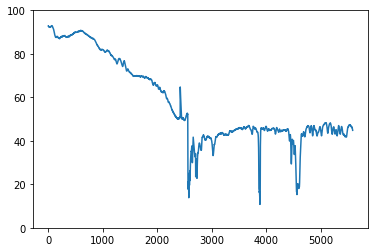

In [3]:
# for i, row in atl06_data.iterrows():
row = atl06_data.iloc[40] #40 is the trace used in other notebook

#display(row)

# arc.find_the_rifts line 262
# arc.get_rifts 350
rift_list = arc.find_the_rifts(row["h"] - row["geoid"]- row["tides"])
#rift_list = arc.find_the_rifts(row['h'])

print(rift_list)

import matplotlib.pyplot as plt
plt.plot(row['h'])
plt.ylim((0,100))

rift detector found 2 rifts
(3878, 3889)
(4562, 4563)


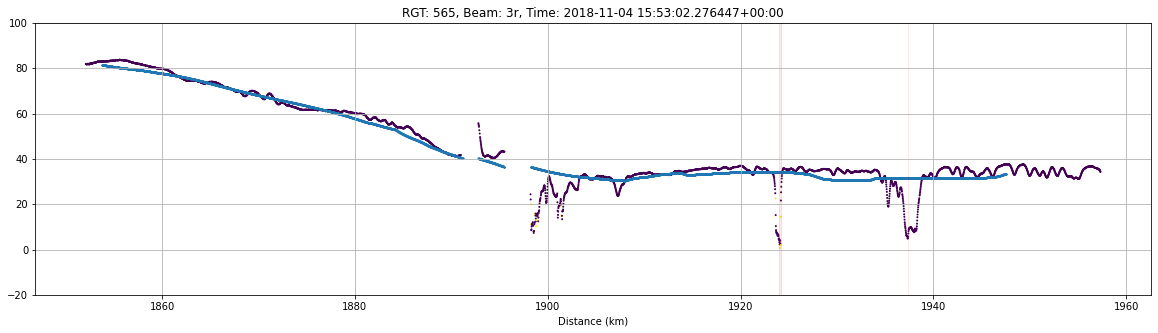

In [4]:
# plot to look like QC

from matplotlib.patches import Rectangle

fig,ax=plt.subplots(figsize=(20,5))

d = np.sqrt(row["x"]**2 + row["y"]**2) / 1000 #distance in km
h = row["h"] - row["geoid"]- row["tides"]

#uncomment these two lines to filter out quality == 1 flags
#but removing them stops the simple running mean from working properly
#h_qual = row["quality"]
#h_filt = np.where(h_qual == 1, np.NaN, h)

# make a rolling average
# May want to exclude quality flag 1
# or do we exclude things with large jumps? (>200m?)
# platelet is 40m, half overlapping
# 1km either side (2km) = 100, 10 km (20km) 1000 etc

# could use something more advanced

# Potential problem here is going to be the ends
# near grounding line and calving front that are cut off
# and get larger as the smoothing distance increases

def running_mean(x,N):
    cumsum = np.cumsum(np.insert(x,0,0))
    return(cumsum[N:] - cumsum[:-N]) / float(N)

run_length = 1000
h_run = running_mean(h,run_length+1)
d_run = d[int(run_length/2):int(len(d)-(run_length/2))]

#plt.scatter(d,row["h"],c=row["quality"])
plt.scatter(d,h,s=1,c=row["quality"])
plt.scatter(d_run,h_run,s=1)
#plt.scatter(d,h_run_nan)

plt.title('RGT: %i, Beam: %s, Time: %s'%(row["rgt"],row["beam"],row["time"]))
plt.xlabel('Distance (km)')

plot_min = -20
plot_max = 100

nr_rifts = len(rift_list)
print("rift detector found " + str(nr_rifts) + " rifts")

for rift in rift_list:
    print(rift)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

plt.ylim((plot_min,plot_max))
#plt.xlim(1900,1910)
plt.grid()
plt.show()

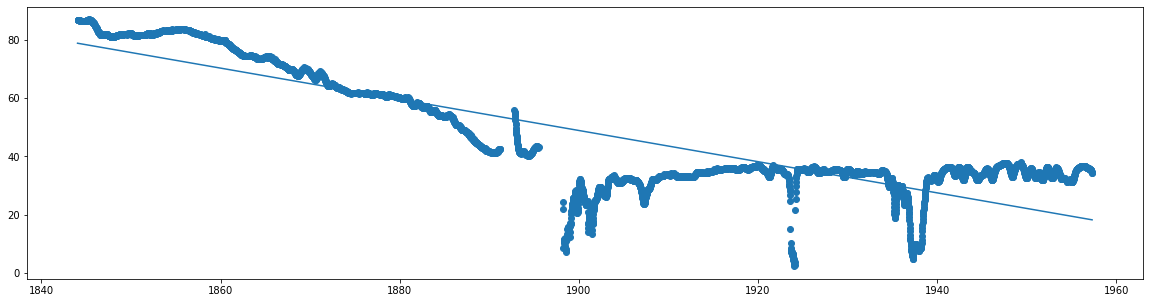

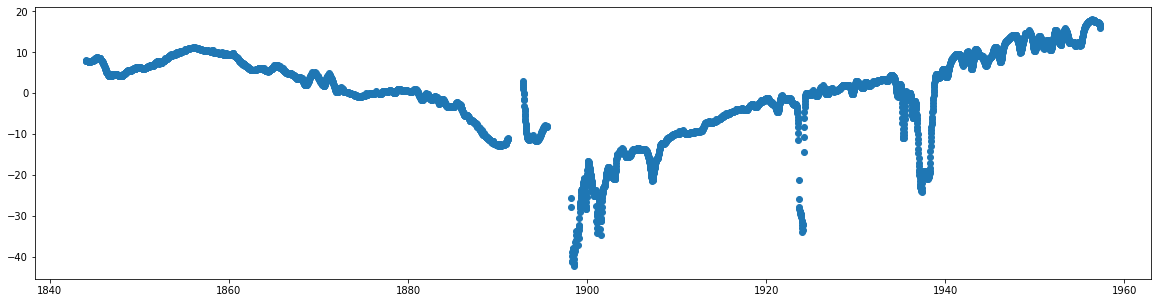

In [5]:
from sklearn.linear_model import LinearRegression

# lets try removing the bad values
# ie flagged as 1 by ATL06 processor

h_qual = row["quality"]
h_filt = np.where(h_qual == 1, np.NaN, h)
#print(len(h_qual))
d_test = d[~np.isnan(h_filt)]
h_test = h_filt[~np.isnan(h_filt)]
#print(len(h_test))
#print(len(d_test))

h_test = h_test.reshape(-1,1)
d_test = d_test.reshape(-1,1)

model = LinearRegression().fit(d_test,h_test)

trend = model.predict(d_test)

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_test,h_test)
plt.plot(d_test,trend)
plt.show()

h_detrend = [h_test[j]-trend[j] for j in range(0, len(h_test))]

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_test,h_detrend)
plt.show()

# but removing the flagged points makes gaps
# maybe a problem if clustered together

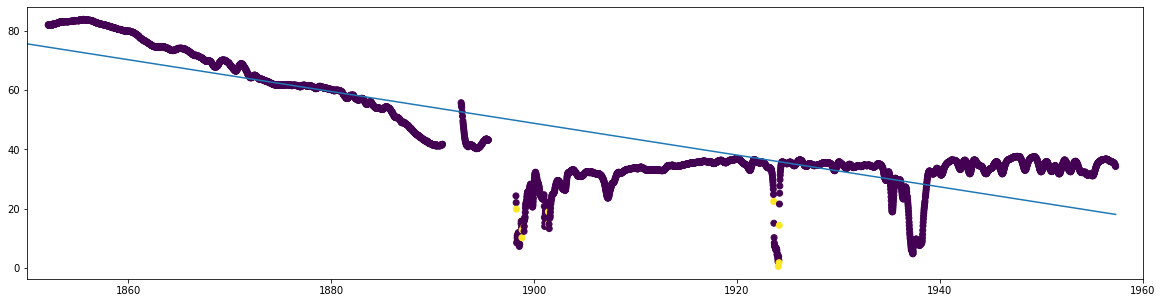

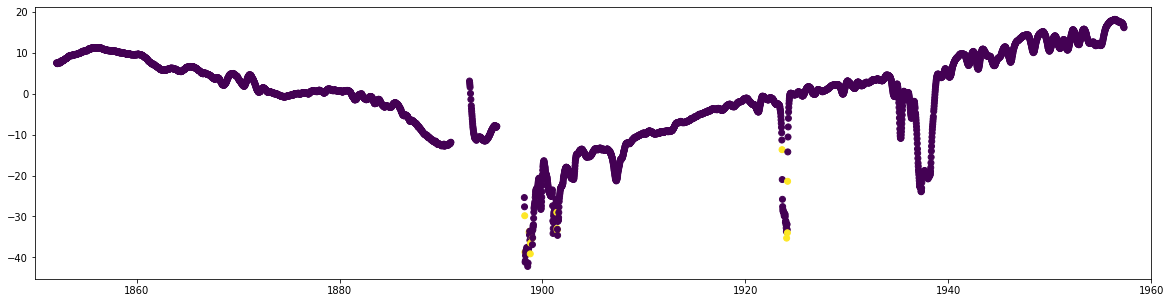

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.signal import butter, filtfilt

h_4lr = h.reshape(-1,1)
d_4lr = d.reshape(-1,1)

model = LinearRegression().fit(d_4lr,h_4lr)

trend = model.predict(d_4lr)

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_4lr,h_4lr,c=row["quality"])
plt.plot(d_4lr,trend)
plt.xlim(1850,1960)
plt.show()

h_detrend = [h_4lr[j]-trend[j] for j in range(0, len(h_4lr))]

fig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d_4lr,h_detrend,c=row["quality"])
plt.xlim(1850,1960)
plt.show()

# and now try a low pass filter

#fig,ax=plt.subplots(figsize=(20,5))
#plt.scatter(d_4lr,h_lowpass,c=row["quality"])
#plt.xlim(1850,1960)
#plt.show()    

Zoom in on the detected rifts

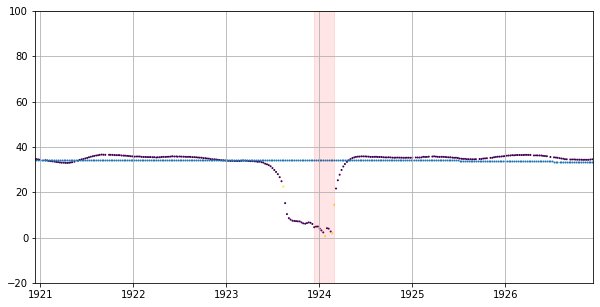

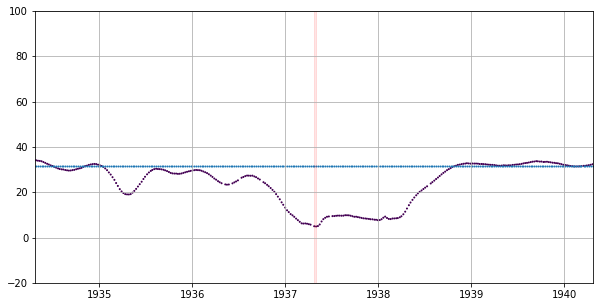

h     5586
d     5586
h_run 4586
d_run 4586


In [7]:
from matplotlib.patches import Rectangle

# make plot zoomed in on each rift (up to max_plots)
dist_around_rift = 3 #km
max_plots = 3
if len(rift_list) < max_plots:
    max_plots = len(rift_list)

# loop through plotting approx. 3 km either side of detected rift

plot_min = -20
plot_max = 100

i=0 #initialise
for rift in rift_list:
    i += 1
    if i > max_plots:
        break
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d,h,s=1,c=row["quality"])
    plt.scatter(d_run,h_run,s=1)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

    plt.ylim(plot_min,plot_max)
    plt.xlim(dist_start-3,dist_start+3)
    plt.grid()
    plt.show()
    
print('h     ' + str(len(h))) 
print('d     ' + str(len(d)))
print('h_run ' + str(len(h_run)))
print('d_run ' + str(len(d_run)))

#first rift (3878,3889)
#second rift (4562, 4563)    

Zoom in on detected rift


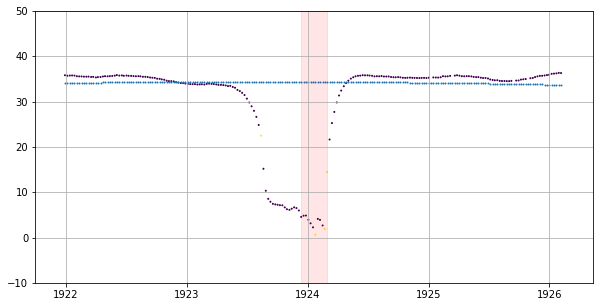

plot the theta/slope difference and h difference
manually define the rift extent (for now) 


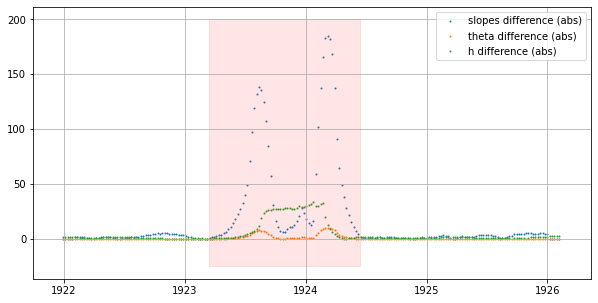

show manually defined extent on zoomed in rift plot


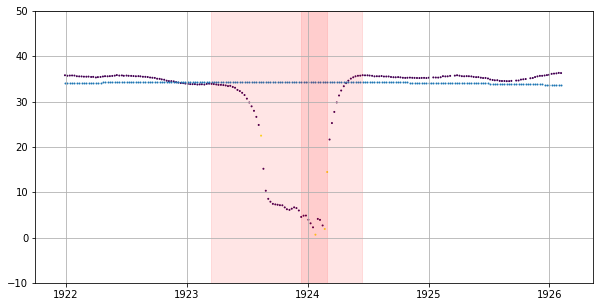

plot the angles


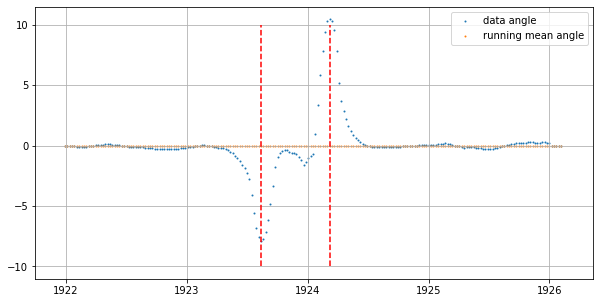

now see how this looks on the rift


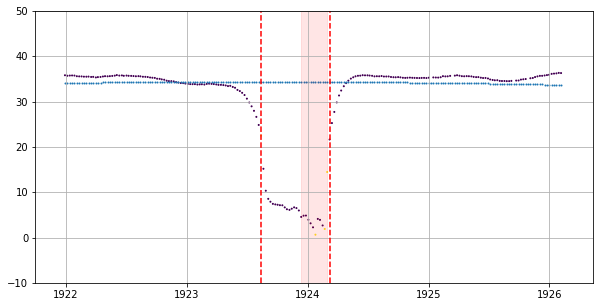

rift width is 0.57 km
rift width measure locations - min: 83 max: 112
full walls estimated locations - min: 63 max: 127


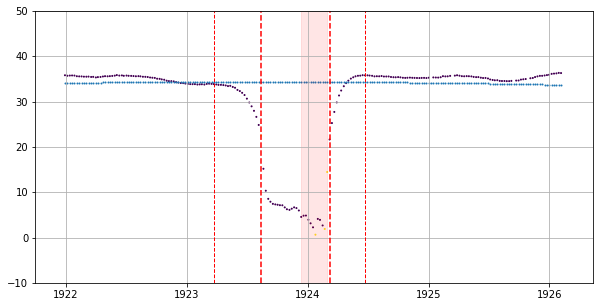

elevation upglacier  : 33.87 m
elevation downglacier: 35.8 m


In [8]:
# the running mean will always (?) be lower than the rift edges
# because of the below average points in the rift dragging down
# the average value 
#
# take a segment either side of the detection
# several km larger than the rift 
# but below rift separation
# is this possible?
#
# idea 1:
# calculate average offset between the rift and running mean
# take out large values (ie in the rift)
# use to move the average surface upwards
# rift edge is where the two meet.
#
# probably not that robust
#
# idea 2:
# running linear regression of data and surface
# rift edge where they agree to within a certain tolerance
# and probably some h difference
# to avoid identifying flat melange as ice shelf surface

#first rift (3878,3889)
#2km around detected rift
#1=20m, 100=2000m

#from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from matplotlib.patches import Rectangle
import math

h_sub = h[3778:3989]
d_sub = d[3778:3989]
q = row["quality"]
q_sub = q[3778:3989]
h_run_sub = h_run[3278:3489]
d_run_sub = d_run[3278:3489]

print("Zoom in on detected rift")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

# linear regression and average h
# through h and h_run

#def running_mean(x,N):
#    cumsum = np.cumsum(np.insert(x,0,0))
#    return(cumsum[N:] - cumsum[:-N]) / float(N)

#run_length = 10
#h_test = running_mean(h_run_sub,run_length+1)

#print(len(h_run_sub))
#print(len(h_test))

#test = np.cumsum(np.insert(h_run_sub,0,0))
#print(test)
h_11 = h_run_sub[0:11]
d_11 = d_run_sub[0:11]
#print(h_11)
#print(len(h_11))
#print(h_run_sub)

#h_11 = h_11.reshape(-1,1)
#d_11 = d_11.reshape(-1,1)

sl_11 = linregress(d_11,h_11).slope

#print(d_11)
#print(h_11)
#print(sl_11)
#model = LinearRegression().fit(d_11,h_11)

#trend = model.predict(d_11)

#print(model)
#print(trend)
slopes_run  = np.zeros(len(h_run_sub))
slopes_data = np.zeros(len(h_sub))
thetas_run  = np.zeros(len(h_run_sub))
thetas_data = np.zeros(len(h_sub))

#211 samples 11 filter, 5 either side so -10
for i in range (5,len(h_run_sub)-5): #(5,6):
    #print(i)
    h_11 = h_run_sub[i-5:i+6]
    d_11 = d_run_sub[i-5:i+6]
    slopes_run[i]=linregress(d_11,h_11).slope
    
    #0 to 180
    #y=mx+c
    slope_run = linregress(d_11,h_11).slope
    inter_run = linregress(d_11,h_11).intercept
    yrun1 = (slope_run * d_11[0]) + inter_run
    yrun2 = (slope_run * d_11[10]) + inter_run
    
    thetas_run[i]= math.degrees(math.atan((yrun2-yrun1)/((d_11[10]-d_11[0])*1000)))
    
    #print(yrun2)
    #print(yrun1)
    #print(yrun2-yrun1)
    #print((d_11[10]-d_11[0])/1000)
    #print(d_11[10])
    #print(d_11[0])
    
    hd_11 = h_sub[i-5:i+6]
    dd_11 = d_sub[i-5:i+6]
    slopes_data[i]=linregress(dd_11,hd_11).slope
    
    slope_data = linregress(dd_11,hd_11).slope
    inter_data = linregress(dd_11,hd_11).intercept
    ydata1 = (slope_data * dd_11[0]) + inter_data
    ydata2 = (slope_data * dd_11[10]) + inter_data
    
    thetas_data[i]= math.degrees(math.atan((ydata2-ydata1)/((dd_11[10]-dd_11[0])*1000)))
    
    

#print(slopes_run)
#print(slopes_data)
    
slopes_diff = abs(slopes_run - slopes_data)
thetas_diff = abs(thetas_run - thetas_data)
h_diff = abs(h_run_sub - h_sub)

print("plot the theta/slope difference and h difference")
print("manually define the rift extent (for now) ")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,slopes_diff,s=1)
plt.scatter(d_sub,thetas_diff,s=1)
plt.scatter(d_sub,h_diff,s=1)
plt.legend(["slopes difference (abs)", "theta difference (abs)", "h difference (abs)"])
#plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)

#do this by eye
ax.add_patch(Rectangle((1923.2,-25),1.25,225,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.grid()
plt.show()

print("show manually defined extent on zoomed in rift plot")

# try this on the original plot
fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((1923.2,-25),1.25,225,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

# so rift edge where h diff and slope diff are close to 0
# what is the rift width?
# full width at half maximum?
# separation of 2 peaks of maximum slope difference?
# (ie the separation of the most vertical parts of the rift?
#print(thetas_run)
#print(thetas_data)
#print(thetas_diff)

thetas_max_pos_km = d_run_sub[np.argmax(thetas_data)]
thetas_min_pos_km = d_run_sub[np.argmin(thetas_data)]


print("plot the angles")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,thetas_data,s=1)
plt.scatter(d_run_sub,thetas_run,s=1)
#plt.scatter(d_run_sub,thetas_diff,s=1)
#plt.legend(["data angle", "running mean angle", "angle difference (abs)"])
plt.legend(["data angle", "running mean angle"])
plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 10], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 10], color = 'r', linestyle = '--')
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("now see how this looks on the rift")

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

rift_width = thetas_max_pos_km - thetas_min_pos_km
print("rift width is "+str(round(rift_width,2))+" km")

thetas_max_pos = np.argmax(thetas_data)
thetas_min_pos = np.argmin(thetas_data)

print("rift width measure locations - min: "+str(thetas_min_pos)+" max: "+str(thetas_max_pos))

thetas_diff_threshold = 0.1 #1

thetas_true = np.where(thetas_diff < thetas_diff_threshold)
thetas_diff_below_before = max(t for t in thetas_true[0] if t < thetas_min_pos)
thetas_diff_below_after = min(t for t in thetas_true[0] if t > thetas_max_pos)
print("full walls estimated locations - min: "+str(thetas_diff_below_before)+" max: "+str(thetas_diff_below_after))

thetas_min_wall_pos_km = d_run_sub[thetas_diff_below_before]
thetas_max_wall_pos_km = d_run_sub[thetas_diff_below_after]

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_wall_pos_km,thetas_min_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)
plt.plot([thetas_max_wall_pos_km,thetas_max_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("elevation upglacier  : "+str(round(h_sub[thetas_diff_below_before],2))+" m")
print("elevation downglacier: "+str(round(h_sub[thetas_diff_below_after],2))+" m")


rift width is 1.37 km
rift width measure locations - min: 82 max: 152
full walls estimated locations - min: 64 max: 185


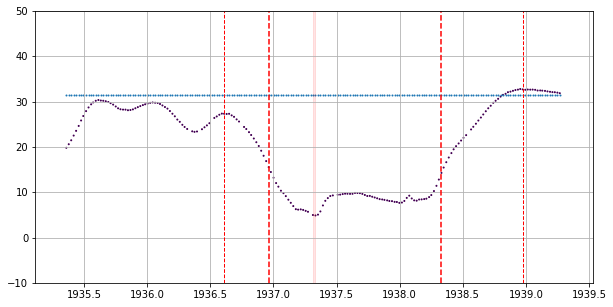

elevation upglacier  : 27.31 m
elevation downglacier: 32.69 m


In [9]:
#first rift (3878,3889)
#second rift (4562, 4563) 

from scipy.stats import linregress
from matplotlib.patches import Rectangle
import math

rift = rift_list[1]

h_sub = h[rift[0]-100:rift[1]+100]
d_sub = d[rift[0]-100:rift[1]+100]
q = row["quality"]
q_sub = q[rift[0]-100:rift[1]+100]
h_run_sub = h_run[rift[0]-100-500:rift[1]+100-500]
d_run_sub = d_run[rift[0]-100-500:rift[1]+100-500]

slopes_run  = np.zeros(len(h_run_sub))
slopes_data = np.zeros(len(h_sub))
thetas_run  = np.zeros(len(h_run_sub))
thetas_data = np.zeros(len(h_sub))

#211 samples 11 filter, 5 either side so -10
for i in range (5,len(h_run_sub)-5): #(5,6):
    #print(i)
    h_11 = h_run_sub[i-5:i+6]
    d_11 = d_run_sub[i-5:i+6]
    slopes_run[i]=linregress(d_11,h_11).slope
    
    #0 to 180
    #y=mx+c
    slope_run = linregress(d_11,h_11).slope
    inter_run = linregress(d_11,h_11).intercept
    yrun1 = (slope_run * d_11[0]) + inter_run
    yrun2 = (slope_run * d_11[10]) + inter_run
    
    thetas_run[i]= math.degrees(math.atan((yrun2-yrun1)/((d_11[10]-d_11[0])*1000)))
    
    hd_11 = h_sub[i-5:i+6]
    dd_11 = d_sub[i-5:i+6]
    slopes_data[i]=linregress(dd_11,hd_11).slope
    
    slope_data = linregress(dd_11,hd_11).slope
    inter_data = linregress(dd_11,hd_11).intercept
    ydata1 = (slope_data * dd_11[0]) + inter_data
    ydata2 = (slope_data * dd_11[10]) + inter_data
    
    thetas_data[i]= math.degrees(math.atan((ydata2-ydata1)/((dd_11[10]-dd_11[0])*1000)))
    
slopes_diff = abs(slopes_run - slopes_data)
thetas_diff = abs(thetas_run - thetas_data)
h_diff = abs(h_run_sub - h_sub)

thetas_max_pos_km = d_run_sub[np.argmax(thetas_data)]
thetas_min_pos_km = d_run_sub[np.argmin(thetas_data)]
    
rift_width = thetas_max_pos_km - thetas_min_pos_km
print("rift width is "+str(round(rift_width,2))+" km")

thetas_max_pos = np.argmax(thetas_data)
thetas_min_pos = np.argmin(thetas_data)

print("rift width measure locations - min: "+str(thetas_min_pos)+" max: "+str(thetas_max_pos))

thetas_diff_threshold = 0.1 #1

thetas_true = np.where(thetas_diff < thetas_diff_threshold)
thetas_diff_below_before = max(t for t in thetas_true[0] if t < thetas_min_pos)
thetas_diff_below_after = min(t for t in thetas_true[0] if t > thetas_max_pos)
print("full walls estimated locations - min: "+str(thetas_diff_below_before)+" max: "+str(thetas_diff_below_after))

thetas_min_wall_pos_km = d_run_sub[thetas_diff_below_before]
thetas_max_wall_pos_km = d_run_sub[thetas_diff_below_after]

fig,ax=plt.subplots(figsize=(10,5))
plt.scatter(d_sub,h_sub,s=1,c=q_sub)
plt.scatter(d_run_sub,h_run_sub,s=1)
#rift = rift_list[0] #first rift detected, the simple one!
rift_start = rift[0]
rift_end   = rift[1]
dist_start = d[rift_start]
dist_end   = d[rift_end]
dist_rift  = dist_end - dist_start
ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
            edgecolor = 'red',
            facecolor = 'red',
            alpha = 0.1))

plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 50], color = 'r', linestyle = '--')
plt.plot([thetas_min_wall_pos_km,thetas_min_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)
plt.plot([thetas_max_wall_pos_km,thetas_max_wall_pos_km],[-10, 50], color = 'r', linestyle = '--', linewidth = 1.0)

plot_min = -10
plot_max = 50

plt.ylim(plot_min,plot_max)
plt.xlim(dist_start-2.2,dist_end+2.2)
plt.grid()
plt.show()

print("elevation upglacier  : "+str(round(h_sub[thetas_diff_below_before],2))+" m")
print("elevation downglacier: "+str(round(h_sub[thetas_diff_below_after],2))+" m")

# second (more complex) rift upglacier wall is maybe peak just after 1936 km
# could place additional condition on h difference?


# on a sequence of passes

ATL06 data loaded from pickle.
0
1
3


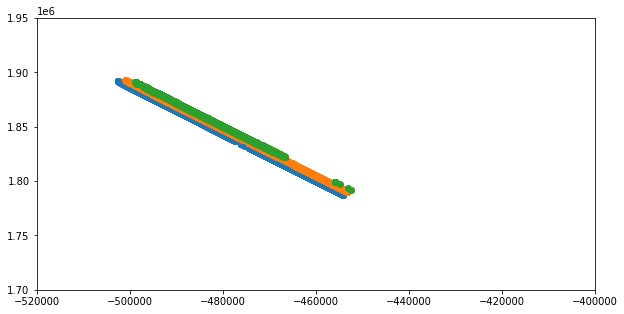

[(3878, 3889), (4562, 4563)]


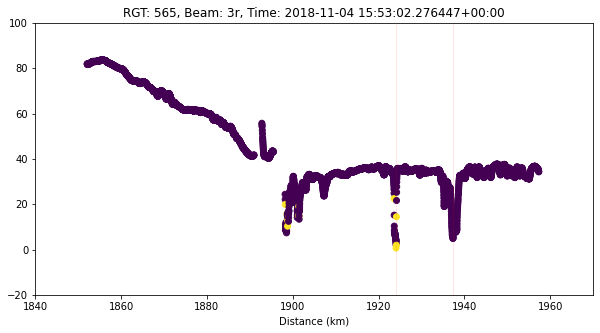

[(3679, 3680), (3682, 3687), (3688, 3689), (4309, 4310)]


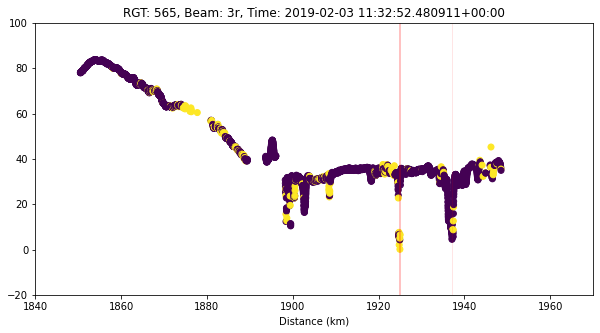

[(4, 5), (6, 7), (10, 11), (12, 17), (18, 27), (28, 29), (37, 38), (39, 40), (49, 50), (51, 58), (71, 76), (77, 79), (80, 81), (84, 85), (86, 87), (88, 89), (90, 91), (92, 93), (94, 97), (99, 100), (101, 104), (107, 108), (109, 110), (128, 129), (130, 131), (135, 137), (146, 147), (149, 150), (151, 152), (155, 156), (180, 181), (182, 183), (197, 198), (199, 200), (201, 211), (212, 213), (214, 215), (221, 222), (224, 228), (253, 254), (255, 256), (257, 258), (259, 260), (291, 292), (293, 294), (344, 345), (346, 347), (368, 369), (372, 373), (374, 375), (376, 377), (392, 393), (394, 395), (396, 397), (398, 399), (400, 401), (402, 403), (412, 413), (414, 416), (417, 418), (419, 420), (493, 494), (495, 496), (497, 498), (1475, 1476), (2071, 2073), (2076, 2079), (2080, 2081), (2611, 2612), (2621, 2622), (2623, 2624), (2639, 2641), (2646, 2648), (2660, 2661), (2662, 2663), (2664, 2665), (2666, 2667), (2672, 2673), (2676, 2679), (2683, 2688), (2693, 2694), (2695, 2700), (2704, 2705), (2706, 2

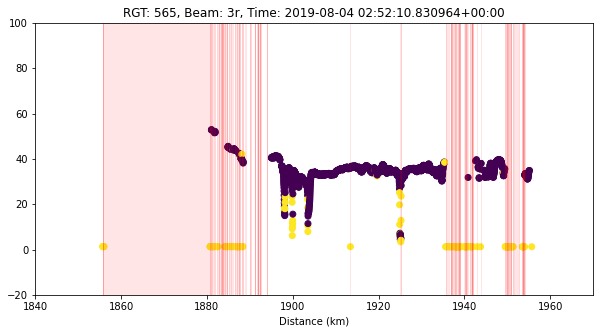

In [50]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


shelf_name='brunt'

# new data location
atl06_file_name = '/data/fast1/arc/atl06/' + shelf_name + '.pkl'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')

#print(atl06_data)
# x y x_atc h lat lon azimuth quality geoid h_sig rgt time beam tides

atl06_data_rgt565 = atl06_data[atl06_data.rgt == 565]
atl06_loc_rgt565 = atl06_data.rgt == 565
#print(atl06_loc_rgt565[250:260])

#print(atl06_data_rgt565)
#print(len(atl06_data_rgt565))
#passes565 = [0,1]
passes565 = [0,1,3] #run with this for gross error on 3rd pass
#passes565 = [6,7,8]
fig,ax=plt.subplots(figsize=(10,5))
for i in passes565: #range (0,len(atl06_data_rgt565)): 
    #display(atl06_data_rgt565.iloc[i])
    print(i)
    row = atl06_data_rgt565.iloc[i]
    #fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(row['x'],row['y'])#,c=row['quality'])
plt.xlim(-520000,-400000)
plt.ylim(1700000,1950000)
plt.show()

plot_min = -20
plot_max = 100
for i in passes565:
    row = atl06_data_rgt565.iloc[i]
    d = np.sqrt(row["x"]**2 + row["y"]**2) / 1000 #distance in km
    ht = row["h"] - row["geoid"]- row["tides"]
    q = row["quality"]
    rift_list = arc.find_the_rifts(ht)
    print(rift_list)
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d,ht,c=q)
    for rift in rift_list:
        rift_start = rift[0]
        rift_end   = rift[1]
        dist_start = d[rift_start]
        dist_end   = d[rift_end]
        dist_rift  = dist_end - dist_start
        ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                    edgecolor = 'red',
                    facecolor = 'red',
                    alpha = 0.1))
    plt.ylim(plot_min,plot_max)
    plt.xlim(1840,1970)
    plt.title('RGT: %i, Beam: %s, Time: %s'%(row["rgt"],row["beam"],row["time"]))
    plt.xlabel('Distance (km)')
    plt.show()
    


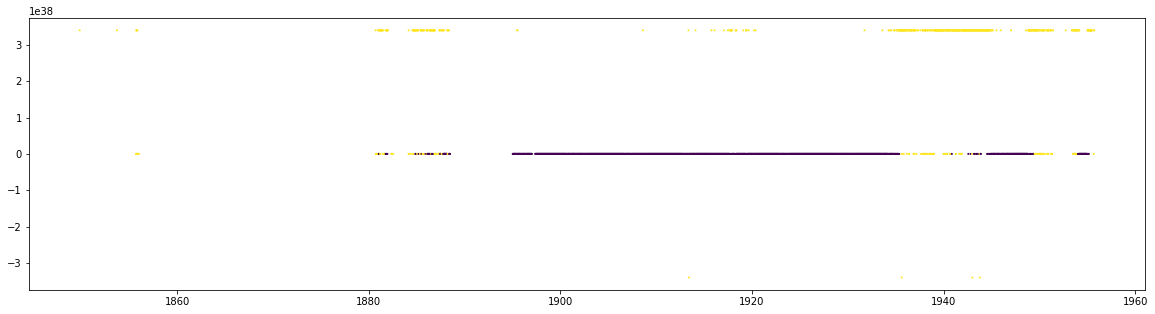

[(1680, 1682), (1685, 1688)]
number of data points (original): 3443
number of data points (filtered): 2460
percentage bad data (original): 29.45106012198664%
percentage bad data (filtered): 1.5447154471544715%


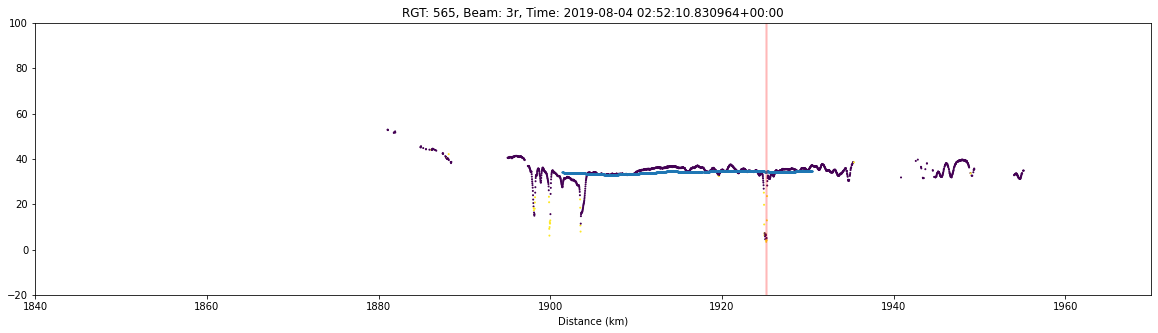

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import arc

test=(atl06_data_rgt565.iloc[3])

#display(test)

#contents
'''
x       vector
y       vector
x_atc   vector
h       vector
lat     vector
lon     vector
azimuth vector
quality vector
geoid   vector
h_sig   vector
rgt     single value
time    single value
beam    single value
tides   vector
'''
#display("x:"+str(len(test["x"])))
#display("y:"+str(len(test["y"])))
#display("x_atc:"+str(len(test["x_atc"])))
#display("h:"+str(len(test["h"])))
#display("lat:"+str(len(test["lat"])))
#display("lon:"+str(len(test["lon"])))
#display("az:"+str(len(test["azimuth"])))
#display("quality:"+str(len(test["quality"])))
#display("geoid:"+str(len(test["geoid"])))
#display("h_sig:"+str(len(test["h_sig"])))
#display("tides:"+str(len(test["tides"])))

#make a new "quality" vector
#ignore the inbuilt quality vector, we want to keep a lot of the "bad" data
#use this to define points where:
#h, geoid are lt/gt 1e38!
test_h = test["h"]
test_geoid = test["geoid"]
test_tides = test["tides"]
test_quality = test["quality"]
#new_quality = np.zeros(len(h))

#display(test_h[1:100])
#display(test_geoid[1:100])

threshold = 1e+38 # can be much stricter on this in h! its the nan value for geoid

new_quality = np.where((test_h>threshold) | (test_h<-threshold) | (test_geoid>threshold) | (test_geoid<-threshold), 1, 0)
#display(new_quality[1:100])

d = np.sqrt(test["x"]**2 + test["y"]**2) / 1000 #distance in km
h = test_h - test_geoid - test_tides

#display(d[1:100])

plot_min = -20
plot_max = 100

ig,ax=plt.subplots(figsize=(20,5))
plt.scatter(d,h,c=new_quality,s=1)
plt.show()

#pass find_the_rifts the filtered list
rift_list = arc.find_the_rifts(h[new_quality==0])
print(rift_list)

dnq = d[new_quality==0]
hnq = h[new_quality==0]
qnq = test_quality[new_quality==0]

#naive running mean
def running_mean(x,N):
    cumsum = np.cumsum(np.insert(x,0,0))
    return(cumsum[N:] - cumsum[:-N]) / float(N)

run_length = 1000
h_run = running_mean(hnq,run_length+1)
d_run = dnq[int(run_length/2):int(len(dnq)-(run_length/2))]

#what does this mean for the quality of the pass
percent_bad = (sum(test_quality)/len(test_quality))*100
percent_bad_new = (sum(test_quality[new_quality==0])/len(test_quality[new_quality==0]))*100
print("number of data points (original): "+str(len(test_quality)))
print("number of data points (filtered): "+str(len(test_quality[new_quality==0])))
print("percentage bad data (original): "+str(percent_bad)+"%")
print("percentage bad data (filtered): "+str(percent_bad_new)+"%")

ig,ax=plt.subplots(figsize=(20,5))
#plt.scatter(d[new_quality==0],h[new_quality==0],c=test_quality[new_quality==0])
plt.scatter(dnq,hnq,c=qnq,s=1)
plt.scatter(d_run,h_run,s=1)
for rift in rift_list:
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = dnq[rift_start]
    dist_end   = dnq[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                           edgecolor = 'red',
                           facecolor = 'red',
                           alpha = 0.1))   
plt.ylim(plot_min,plot_max)
plt.xlim(1840,1970)
plt.title('RGT: %i, Beam: %s, Time: %s'%(test["rgt"],test["beam"],test["time"]))
plt.xlabel('Distance (km)') 
plt.show()
    


ATL06 data loaded from pickle.
------------------------------


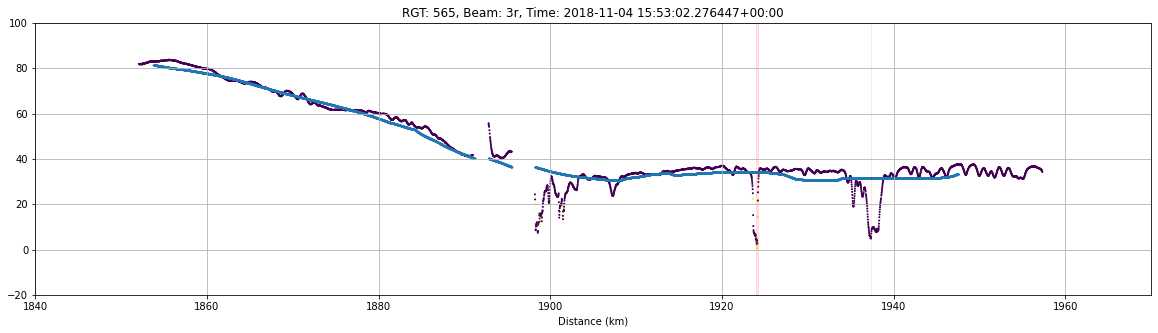

---
number of data points (original): 5586
number of data points (filtered): 5586
percentage bad data (original): 0.26852846401718583%
percentage bad data (filtered): 0.26852846401718583%
---
rift_list:
[(3878, 3889), (4562, 4563)]
---
manually amended rift list (TEMPORARY):
[(3878, 3889), (4562, 4563)]
---


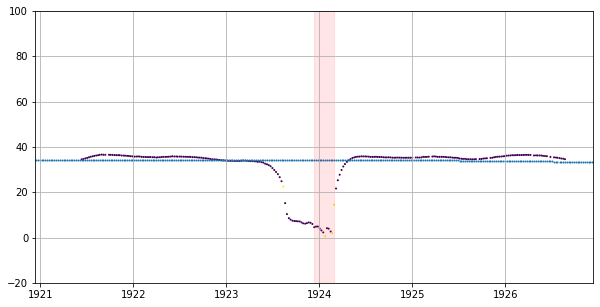

---
rift width is 0.57 km
rift width measure locations - min: 111 max: 140
---


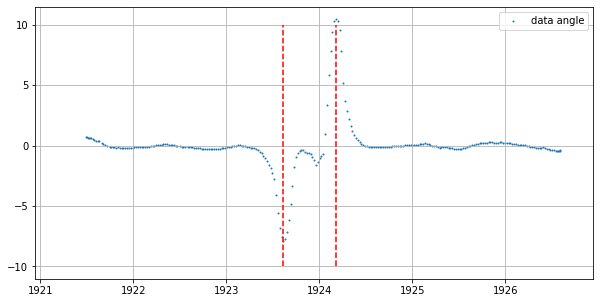

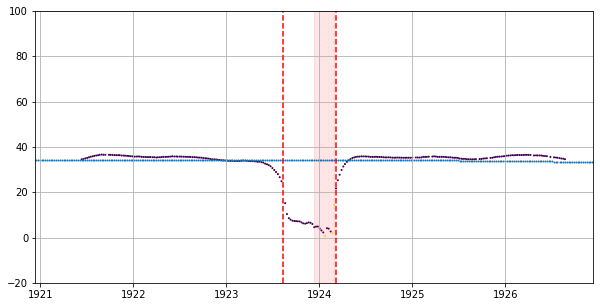

------------------------------


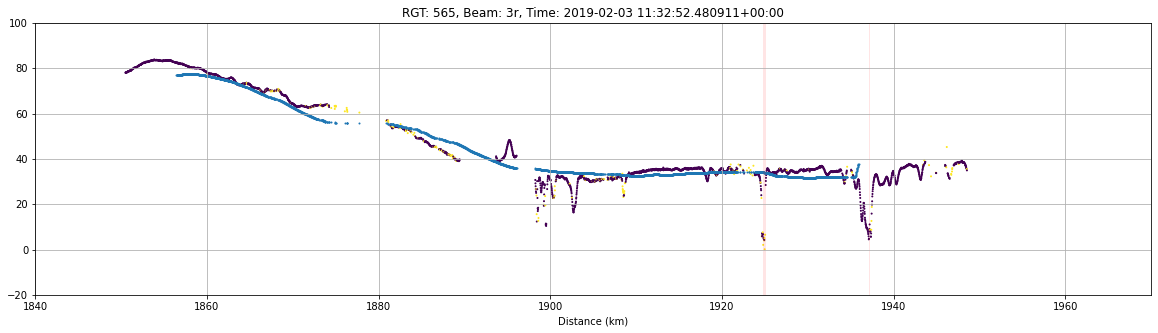

---
number of data points (original): 4952
number of data points (filtered): 4058
percentage bad data (original): 23.06138933764136%
percentage bad data (filtered): 6.1113849186791525%
---
rift_list:
[(3060, 3061), (3062, 3067), (3068, 3069), (3618, 3619)]
---
manually amended rift list (TEMPORARY):
[(3060, 3069), (3618, 3619)]
---


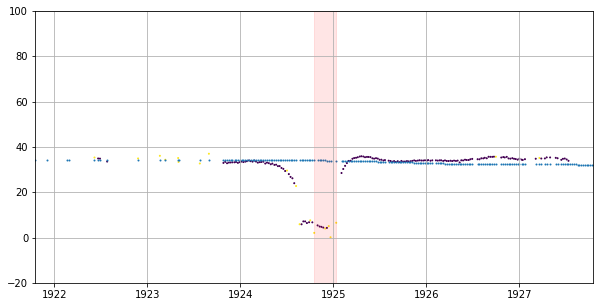

---
rift width is 0.45 km
rift width measure locations - min: 40 max: 58
---


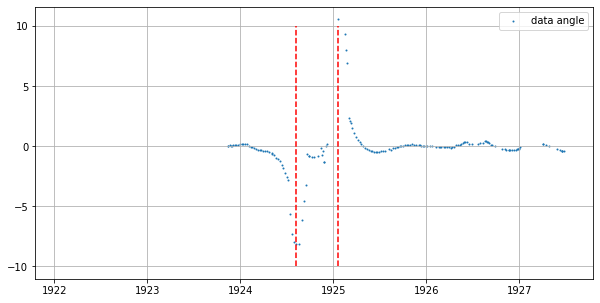

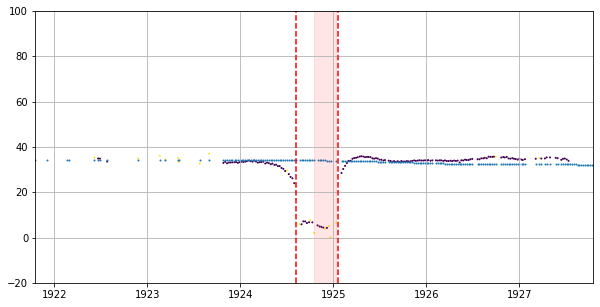

------------------------------


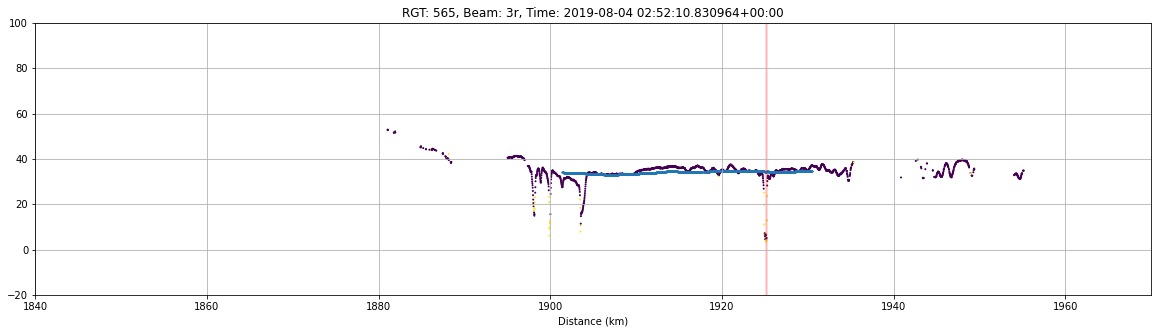

---
number of data points (original): 3443
number of data points (filtered): 2460
percentage bad data (original): 29.45106012198664%
percentage bad data (filtered): 1.5447154471544715%
---
rift_list:
[(1680, 1682), (1685, 1688)]
---
manually amended rift list (TEMPORARY):
[(1680, 1688)]
---


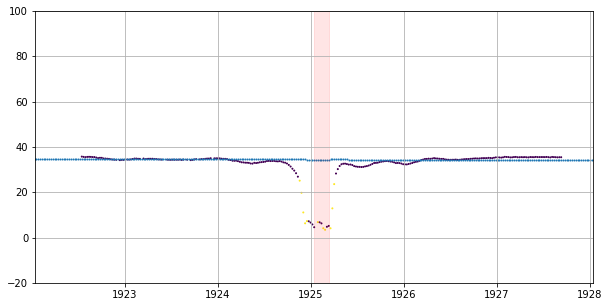

---
rift width is 0.35 km
rift width measure locations - min: 121 max: 139
---


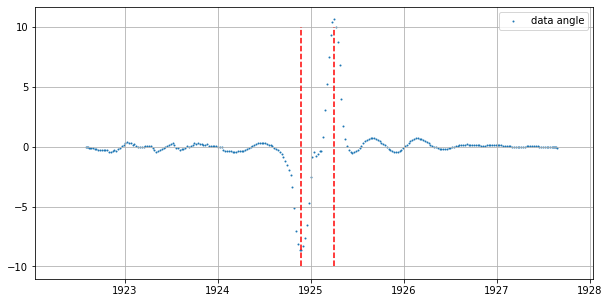

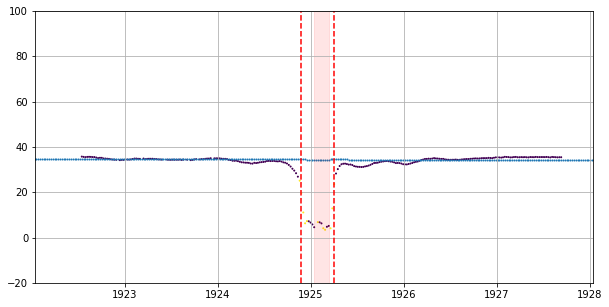

------------------------------
[Timestamp('2018-11-04 15:53:02.276447+0000', tz='tzutc()'), Timestamp('2019-02-03 11:32:52.480911+0000', tz='tzutc()'), Timestamp('2019-08-04 02:52:10.830964+0000', tz='tzutc()')]
[0.5664056891944256, 0.44828640093805916, 0.351491879485593]


In [128]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import linregress
import math


shelf_name='brunt'

# new data location
atl06_file_name = '/data/fast1/arc/atl06/' + shelf_name + '.pkl'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')
    print("------------------------------")

#print(atl06_data)
# x y x_atc h lat lon azimuth quality geoid h_sig rgt time beam tides

atl06_data_rgt565 = atl06_data[atl06_data.rgt == 565]
atl06_loc_rgt565 = atl06_data.rgt == 565
#print(atl06_loc_rgt565[250:260])

#pick out closely repeating passes
passes565 = [0,1,3]
#passes565 = [6,7,8]

plot_min = -20
plot_max = 100

threshold = 1e+38 #h and geoid NaN filtering

the_date = []
the_widths = []

for i in passes565:
    #define the trace
    row = atl06_data_rgt565.iloc[i]
    #extract height, geoid, tides and quality (of ATL06)
    h = row["h"]
    geoid = row["geoid"]
    tides = row["tides"]
    quality = row["quality"]
    the_date.append(row["time"])
    
    
    #define new_quality filter to remove NaNs
    new_quality = np.where((h>threshold) | (h<-threshold) | (geoid>threshold) | (geoid<-threshold), 1, 0)
    d = np.sqrt(row["x"]**2 + row["y"]**2) / 1000 #distance in km
    ht = h - geoid - tides
    d_nq = d[new_quality==0]
    ht_nq = ht[new_quality==0]
    qual_nq = quality[new_quality==0]
    
    #naive running mean (TEMPORARY)
    #good enough for first rift for now!
    def running_mean(x,N):
        cumsum = np.cumsum(np.insert(x,0,0))
        return(cumsum[N:] - cumsum[:-N]) / float(N)

    run_length = 1000
    h_run = running_mean(ht_nq,run_length+1)
    d_run = d_nq[int(run_length/2):int(len(d_nq)-(run_length/2))]

    
    #call find_the_rifts
    rift_list = arc.find_the_rifts(ht_nq)
    
    #plot it
    fig,ax=plt.subplots(figsize=(20,5))
    plt.scatter(d_nq,ht_nq,c=qual_nq,s=1)
    plt.scatter(d_run,h_run,s=1)
    for rift in rift_list:
        rift_start = rift[0]
        rift_end   = rift[1]
        dist_start = d_nq[rift_start]
        dist_end   = d_nq[rift_end]
        dist_rift  = dist_end - dist_start
        ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                    edgecolor = 'red',
                    facecolor = 'red',
                    alpha = 0.1))
    plt.ylim(plot_min,plot_max)
    plt.xlim(1840,1970)
    plt.title('RGT: %i, Beam: %s, Time: %s'%(row["rgt"],row["beam"],row["time"]))
    plt.xlabel('Distance (km)')
    plt.grid()
    plt.show()
    
    #print out the quality
    percent_bad = (sum(quality)/len(quality))*100
    percent_bad_new = (sum(qual_nq)/len(qual_nq))*100
    print("---")
    print("number of data points (original): "+str(len(quality)))
    print("number of data points (filtered): "+str(len(qual_nq)))
    print("percentage bad data (original): "+str(percent_bad)+"%")
    print("percentage bad data (filtered): "+str(percent_bad_new)+"%")
    print("---")

    #print out the rift list
    print("rift_list:")
    print(rift_list)
    print("---")
    
    #this is just until we solve the problem of mulitple detections of same rift
    print("manually amended rift list (TEMPORARY):")
    if i == 0:
        print(rift_list)
    if i == 1:
        rift_list = [(3060, 3069), (3618, 3619)]
        print(rift_list)
    if i == 3:
        rift_list = [(1680,1688)]
        print(rift_list)
    print("---")
    
    #zoom in on first detected rift (same first rift found on all passes in this case)
    dist_around_rift = 2.5 #km
    #find index of start and end approx distance away from detection
    rift = rift_list[0]
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d_nq[rift_start]
    dist_end   = d_nq[rift_end]
    dist_rift  = dist_end - dist_start
    idx_around_start = next(x for x, val in enumerate(d_nq) if val > dist_start - 2.5)
    idx_around_end = next(x for x, val in enumerate(d_nq) if val > dist_end + 2.5)
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d_nq[idx_around_start:idx_around_end],ht_nq[idx_around_start:idx_around_end],
                s=1,c=qual_nq[idx_around_start:idx_around_end])
    plt.scatter(d_run,h_run,s=1)
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

    plt.ylim(plot_min,plot_max)
    plt.xlim(dist_start-dist_around_rift-0.5,dist_start+dist_around_rift+0.5)
    plt.grid()
    plt.show()
    
    #work out the surface angle
    d_nq_sub = d_nq[idx_around_start:idx_around_end]
    ht_nq_sub = ht_nq[idx_around_start:idx_around_end]
    
    #initialise array for mini linear regressions
    d_lr = []
    thetas_data = []
    for a in range (0,len(d_nq_sub)):
        dist_min = d_nq_sub[a]-0.1
        dist_max = d_nq_sub[a]+0.1
        #nr_points = sum(np.where((d_nq_sub > dist_min) & (d_nq_sub < dist_max),1,0))
        idx_points = np.where((d_nq_sub > dist_min) & (d_nq_sub < dist_max))
        nr_points = len(idx_points[0])
        if nr_points > 5: #do the linear regression
            #mean of the distance values is representative point
            d_nq_sub_points = d_nq_sub[idx_points]
            d_lr.append(np.mean(d_nq_sub_points))
            #linear regression on these points
            ht_nq_sub_points = ht_nq_sub[idx_points]
            slope_data = linregress(d_nq_sub_points,ht_nq_sub_points).slope
            inter_data = linregress(d_nq_sub_points,ht_nq_sub_points).intercept
            ydata1 = (slope_data * min(d_nq_sub_points)) + inter_data
            ydata2 = (slope_data * max(d_nq_sub_points)) + inter_data
            thetas_data.append(math.degrees(math.atan((ydata2-ydata1)/((max(d_nq_sub_points)-min(d_nq_sub_points))*1000))))
            
    #find max magnitude surface slopes
    thetas_max_pos_km = d_lr[np.argmax(thetas_data)]
    thetas_min_pos_km = d_lr[np.argmin(thetas_data)]
    
    rift_width = thetas_max_pos_km - thetas_min_pos_km
    the_widths.append(rift_width)
    print("---")
    print("rift width is "+str(round(rift_width,2))+" km")

    
    
    thetas_max_pos = np.argmax(thetas_data)
    thetas_min_pos = np.argmin(thetas_data)

    print("rift width measure locations - min: "+str(thetas_min_pos)+" max: "+str(thetas_max_pos))
    print("---")
    
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d_lr,thetas_data,s=1)
    #plt.scatter(d_run_sub,thetas_run,s=1)
    #plt.legend(["data angle", "running mean angle"])
    plt.legend(["data angle"])
    plt.plot([thetas_max_pos_km,thetas_max_pos_km],[-10, 10], color = 'r', linestyle = '--')
    plt.plot([thetas_min_pos_km,thetas_min_pos_km],[-10, 10], color = 'r', linestyle = '--')
    plt.xlim(dist_start-dist_around_rift-0.5,dist_start+dist_around_rift+0.5)
    plt.grid()
    plt.show()
            
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d_nq[idx_around_start:idx_around_end],ht_nq[idx_around_start:idx_around_end],
                s=1,c=qual_nq[idx_around_start:idx_around_end])
    plt.scatter(d_run,h_run,s=1)
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))
    plt.plot([thetas_max_pos_km,thetas_max_pos_km],[plot_min, plot_max], color = 'r', linestyle = '--')
    plt.plot([thetas_min_pos_km,thetas_min_pos_km],[plot_min, plot_max], color = 'r', linestyle = '--')
    plt.ylim(plot_min,plot_max)
    plt.xlim(dist_start-dist_around_rift-0.5,dist_start+dist_around_rift+0.5)
    plt.grid()
    plt.show()
    
    print("------------------------------")
    
print(the_date)
print(the_widths)